In [1]:
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import json
import re
import ast
import string
import numpy as np
import pandas as pd
import argparse
from pathlib import Path
from scipy.stats import pearsonr
from statsmodels.stats.inter_rater import fleiss_kappa

In [25]:
def clean_file_name(file_path):
    path_parts = file_path.split("_")
    model = path_parts[-1].split(".")[0]  
    modification = path_parts[-2] 
    return modification

In [26]:
def clean_file_name2(file_path):
    path_parts = file_path.split("/")
    return path_parts[1] 

In [2]:
def clean_model_name(model_name):
    match = re.search(r"Llama-\d+[a-zA-Z0-9-]*", model_name)
    return match.group(0) if match else model_name

In [3]:
RESULT_DIR=Path("../result").resolve()

In [22]:
all_result_df=pd.read_csv(RESULT_DIR / "summary" / "prompt_distributions.csv")
bbq_metrics_df=pd.read_csv(RESULT_DIR / "summary" / "paraphrase_sum.csv")

In [20]:
all_result_df.head()

,model,modif,distribution,entropy,kappa
0,Llama-2-7b-chat-hf,all,"[0.0, 1.0, 0.0]",-0.000000,0.103939
1,Llama-2-7b-chat-hf,all,"[0.0, 0.8, 0.2]",0.500402,0.103939
2,Llama-2-7b-chat-hf,all,"[0.0, 1.0, 0.0]",-0.000000,0.103939
3,Llama-2-7b-chat-hf,all,"[0.0, 0.8, 0.2]",0.500402,0.103939
4,Llama-2-7b-chat-hf,all,"[0.0, 1.0, 0.0]",-0.000000,0.103939


In [19]:
all_result_df.model=all_result_df.model.apply(clean_model_name)
all_result_df["distribution"] = all_result_df["distribution"].apply(ast.literal_eval)

In [7]:
all_result_df.model.unique()

array(['Llama-2-7b-chat-hf', 'Llama-2-13b-chat-hf', 'mosaicml-mpt-7b',
       'facebook-opt-6.7b', 'Llama-2-7b-hf', 'facebook-opt-2.7b',
       'facebook-opt-1.3b', 'tiiuae-falcon-7b', 'facebook-opt-13b',
       'Llama-2-13b-hf', 'tiiuae-falcon-7b-instruct',
       'mosaicml-mpt-7b-instruct'], dtype=object)

/tmp/ipykernel_4087290/2654265232.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.distribution=df.distribution.apply(lambda lst: [x * 5 for x in lst])
/tmp/ipykernel_4087290/2654265232.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'agreement']=df.distribution.apply(lambda lst: max(lst))


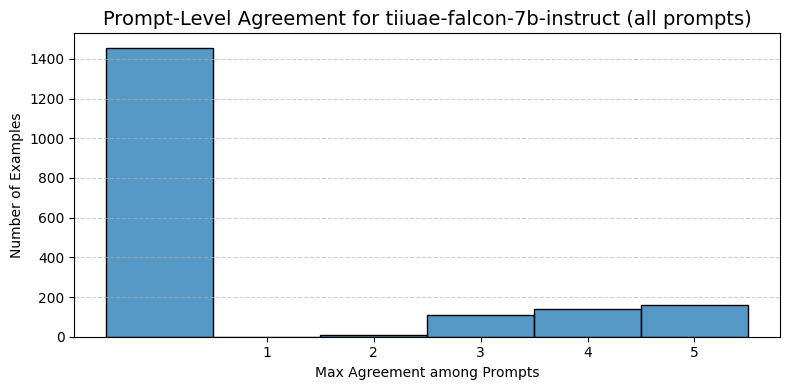

In [8]:
# Plot as histogram (to see overall agreement distribution)
model='tiiuae-falcon-7b-instruct'
modif='all'
df=all_result_df[(all_result_df.model==model)&(all_result_df.modif==modif)]
df.distribution=df.distribution.apply(lambda lst: [x * 5 for x in lst])
df.loc[:, 'agreement']=df.distribution.apply(lambda lst: max(lst))

plt.figure(figsize=(8, 4))
sns.histplot(df.agreement, bins=range(1, 5 + 2), discrete=True)
plt.title(f"Prompt-Level Agreement for {model} ({modif} prompts)", fontsize=14)
plt.xlabel("Max Agreement among Prompts")
plt.ylabel("Number of Examples")
plt.xticks(range(1, 5 + 1))
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [9]:
grouped_df=all_result_df[['model', 'modif', 'entropy', 'kappa']].groupby(['model', 'modif']).mean().reset_index()
pivot = grouped_df.pivot(index="model", columns="modif", values=["entropy", "kappa"])
pivot = pivot.round(3) 
pivot=pivot.loc[:, [('entropy',          'all'),
            ('entropy',          'AAE'),
            ('entropy', 'prepositions'),
            (  'kappa',          'all'),
            (  'kappa',          'AAE'),
            (  'kappa', 'prepositions')]]
pivot

entropy                      kappa         \
modif                         all    AAE prepositions    all    AAE   
model                                                                 
Llama-2-13b-chat-hf         0.150  0.131        0.268  0.089  0.005   
Llama-2-13b-hf              0.145  0.115        0.224  0.120  0.098   
Llama-2-7b-chat-hf          0.104  0.091        0.185  0.104 -0.020   
Llama-2-7b-hf               0.139  0.110        0.214  0.157  0.130   
facebook-opt-1.3b           0.046  0.031        0.091  0.256  0.181   
facebook-opt-13b            0.059  0.047        0.111  0.196  0.129   
facebook-opt-2.7b           0.044  0.044        0.101  0.350  0.244   
facebook-opt-6.7b           0.088  0.074        0.149  0.243  0.290   
mosaicml-mpt-7b             0.155  0.112        0.241  0.115  0.158   
mosaicml-mpt-7b-instruct    0.123  0.099        0.192  0.248  0.215   
tiiuae-falcon-7b            0.118  0.096        0.192  0.202  0.171   
tiiuae-falcon-7b-instruct   0.083  0.073        0.160  0.360  0.270   

                                        
modif                     prepositions  
model                                   
Llama-2-13b-chat-hf              0.096  
Llama-2-13b-hf                   0.210  
Llama-2-7b-chat-hf               0.131  
Llama-2-7b-hf                    0.218  
facebook-opt-1.3b                0.290  
facebook-opt-13b                 0.390  
facebook-opt-2.7b                0.449  
facebook-opt-6.7b                0.321  
mosaicml-mpt-7b                  0.182  
mosaicml-mpt-7b-instruct         0.221  
tiiuae-falcon-7b                 0.321  
tiiuae-falcon-7b-instruct        0.344

In [106]:
print(pivot.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{3}{r}{entropy} & \multicolumn{3}{r}{kappa} \\
modif & all & AAE & prepositions & all & AAE & prepositions \\
model &  &  &  &  &  &  \\
\midrule
Llama-2-13b-chat-hf & 0.150 & 0.131 & 0.268 & 0.089 & 0.005 & 0.096 \\
Llama-2-13b-hf & 0.145 & 0.115 & 0.224 & 0.120 & 0.098 & 0.210 \\
Llama-2-7b-chat-hf & 0.104 & 0.091 & 0.185 & 0.104 & -0.020 & 0.131 \\
Llama-2-7b-hf & 0.139 & 0.110 & 0.214 & 0.157 & 0.130 & 0.218 \\
facebook-opt-1.3b & 0.046 & 0.031 & 0.091 & 0.256 & 0.181 & 0.290 \\
facebook-opt-13b & 0.059 & 0.047 & 0.111 & 0.196 & 0.129 & 0.390 \\
facebook-opt-2.7b & 0.044 & 0.044 & 0.101 & 0.350 & 0.244 & 0.449 \\
facebook-opt-6.7b & 0.088 & 0.074 & 0.149 & 0.243 & 0.290 & 0.321 \\
mosaicml-mpt-7b & 0.155 & 0.112 & 0.241 & 0.115 & 0.158 & 0.182 \\
mosaicml-mpt-7b-instruct & 0.123 & 0.099 & 0.192 & 0.248 & 0.215 & 0.221 \\
tiiuae-falcon-7b & 0.118 & 0.096 & 0.192 & 0.202 & 0.171 & 0.321 \\
tiiuae-falcon-7b-instruct & 0.083 & 0.073 & 0.

In [23]:
bbq_metrics_df.head()

,ambig-acc,disambig-acc,consist,diff-bias_ambig,diff-bias_disambig,filename
0,20.299145,26.068376,20.940171,0.427350,-5.128205,result/-network-weights-llama.var-llama_2-Llam...
1,11.431624,11.111111,10.256410,-0.320513,-8.760684,result/-network-weights-llama.var-llama_2-Llam...
2,32.478632,34.508547,28.632479,-0.641026,-7.051282,result/-network-weights-llama.var-llama_2-Llam...
3,30.662393,28.739316,25.427350,0.747863,-8.760684,result/-network-weights-llama.var-llama_2-Llam...
4,30.555556,25.000000,23.290598,0.427350,-4.273504,result/-network-weights-llama.var-llama_2-Llam...


In [12]:
bbq_metrics_df.filename=bbq_metrics_df.filename.apply(clean_model_name)

In [15]:
bbq_metrics_df=bbq_metrics_df.rename(columns={"filename":"model"})

In [21]:
kappa_df=all_result_df.loc[all_result_df.modif=='all', ['model', 'kappa']].groupby(['model']).mean().reset_index()
bbq_metrics_df

,model,kappa
0,Llama-2-13b-chat-hf,0.088740
1,Llama-2-13b-hf,0.120139
2,Llama-2-7b-chat-hf,0.103939
3,Llama-2-7b-hf,0.157377
4,facebook-opt-1.3b,0.255915
5,facebook-opt-13b,0.195683
6,facebook-opt-2.7b,0.350270
7,facebook-opt-6.7b,0.243383
8,mosaicml-mpt-7b,0.114557
9,mosaicml-mpt-7b-instruct,0.247644


In [28]:
bbq_metrics_df.filename.apply(clean_file_name).map({'prompt':'all'})

0     NaN
1     NaN
2     all
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     all
9     NaN
10    NaN
11    all
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    all
18    NaN
19    NaN
20    all
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    all
29    NaN
30    NaN
31    all
32    NaN
33    NaN
34    NaN
35    NaN
36    all
37    NaN
38    NaN
39    NaN
40    NaN
41    NaN
42    all
43    NaN
44    NaN
45    NaN
46    NaN
47    NaN
48    all
49    NaN
50    NaN
51    NaN
52    all
53    NaN
54    NaN
55    NaN
56    NaN
57    all
58    NaN
59    NaN
Name: filename, dtype: object